In [1]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import matplotlib.pyplot as plt

# Import the data loader from the generic_neuromotor_interface package
from generic_neuromotor_interface.explore_data.load import load_data

DATA_FOLDER = "../data/emg_data/"


In [4]:
from generic_neuromotor_interface.scripts.download_data import download_data

for task in ["discrete_gestures"]:
    download_data(task, "small_subset", DATA_FOLDER)

Unzipping the data...


Extracting files: 100%|███████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


Deleting the tar file after extraction: discrete_gestures_small_subset.tar


Data for discrete_gestures (small_subset) downloaded and extracted to /Users/ackmanadmin/Documents/fall-2025-gesture-recognition/notebooks/../data/emg_data


In [2]:
def get_task_dataset_paths(task: str) -> list[str]:
    folder = os.path.expanduser(DATA_FOLDER)
    datasets = glob.glob(os.path.join(folder, '*.hdf5'))
    # Only return files that contain the task name in their filename
    return [d for d in datasets if task in d]

corpus_csv = os.path.expanduser(os.path.join(DATA_FOLDER, "discrete_gestures_corpus.csv"))
corpus_df = pd.read_csv(corpus_csv)    

files = get_task_dataset_paths("discrete_gestures")
# Print start time for the loop
print("Loop will start now. Start time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(files)

Loop will start now. Start time: 2025-10-02 10:08:05
['../data/emg_data/discrete_gestures_user_002_dataset_000.hdf5', '../data/emg_data/discrete_gestures_user_000_dataset_000.hdf5', '../data/emg_data/discrete_gestures_user_001_dataset_000.hdf5']


In [3]:
file = files[0] #take the first file in the files list
basename = os.path.basename(file)  # Get just the filename (not the full path)
print(f"Processing new file: {basename}")  # Print when starting a new file

parts = basename.split('_')
user_number = parts[3]  # Extract user_number from filename
dataset_number = parts[5].split('.')[0]  # Extract dataset_number from filename

# Find the matching row in the ground truth csv for this file
gt_row = corpus_df[
    (corpus_df['user_number'].astype(str).str.zfill(3) == user_number) &
    (corpus_df['dataset_number'].astype(str).str.zfill(3) == dataset_number)
]
gt_row = gt_row.iloc[0]  # Get the first (and only) matching row
start, end, split = gt_row['start'], gt_row['end'], gt_row['split']

# We'll load the file using the `load_data` utility function.
# Load the EMG data and associated info from single .hdf5 file
data = load_data(file)
emg = data.emg         # EMG signal, shape: (n_samples, 16)
time = data.time       # Timestamps for each sample
prompts = data.prompts # Dataframe of gesture events (name, time)
stages = data.stages   # Dataframe of stage events (start, end, name)



# # For each sample in the EMG recording, build a row for the output dataframe
# for i in range(emg.shape[0]):
#     row = [
#         start, end, split, dataset_number, user_number, basename,  # Keep .hdf5 extension in 'dataset'
#         time[i], stage_labels[i], gesture_labels[i]
#     ] + emg[i].tolist()  # Add all 16 EMG channel values
#     all_rows.append(row)

Processing new file: discrete_gestures_user_002_dataset_000.hdf5


In [5]:
# Prepare an array to hold the gesture label for each sample (default: empty string)
gesture_labels = np.full_like(time, '', dtype=object)
if not prompts.empty:
    prompt_times = prompts['time'].values
    prompt_names = prompts['name'].values
    prompt_idx = 0
    # For each sample, check if a gesture occurs at that timestamp
    for i, t in enumerate(time):
        while prompt_idx + 1 < len(prompt_times) and prompt_times[prompt_idx + 1] <= t:
            prompt_idx += 1
        if prompt_times[prompt_idx] == t:
            gesture_labels[i] = prompt_names[prompt_idx]


### THIS TAKES A LONG TIME <- Not sure if we want to test if the stage has any beneficial outcome of the trials
# # Prepare an array to hold the stage label for each sample (default: empty string)
# stage_labels = np.full_like(time, '', dtype=object)
# if not stages.empty:
#     # For each sample, check if it falls within any stage interval
#     for i, t in enumerate(time):
#         for _, row in stages.iterrows():
#             if row['start'] <= t <= row['end']:
#                 stage_labels[i] = row['name']
#                 break

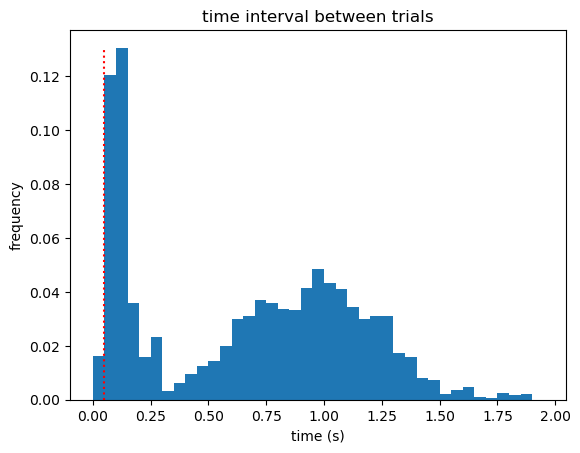

In [26]:
plt.hist(np.diff(prompt_times), 
         weights=np.ones(prompt_times.size-1)/(prompt_times.size-1), 
         bins =np.arange(40)/20)
plt.vlines(0.05, 0, 0.13, color='red', linestyle=':') # lowest window value used to try not to get contamination by other trials
plt.title('time interval between trials')
plt.xlabel('time (s)')
plt.ylabel('frequency')
plt.show()

In [ ]:
all_gestures = np.unique(gesture_labels)
gest_indices = np.where(gesture_labels == all_gestures[1])[0]
# print(stage_labels[gest_indices])

In [47]:
#make zscores based on emg data, normalizes the EMG signals: 0 is mean, 1 is 1stdev, 2 is 2stdev, etc.
zscore = (emg - np.mean(emg, axis=0))/np.std(emg, axis=0)

Lower threshold used index_press 0


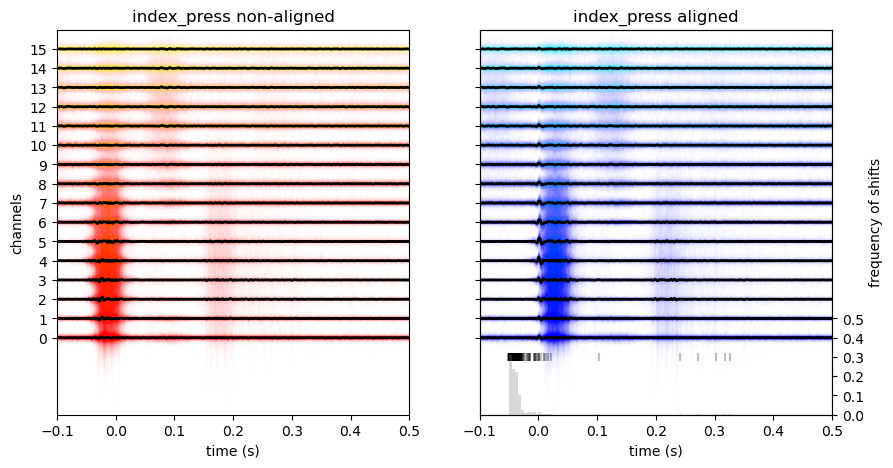

Lower threshold used index_release 0


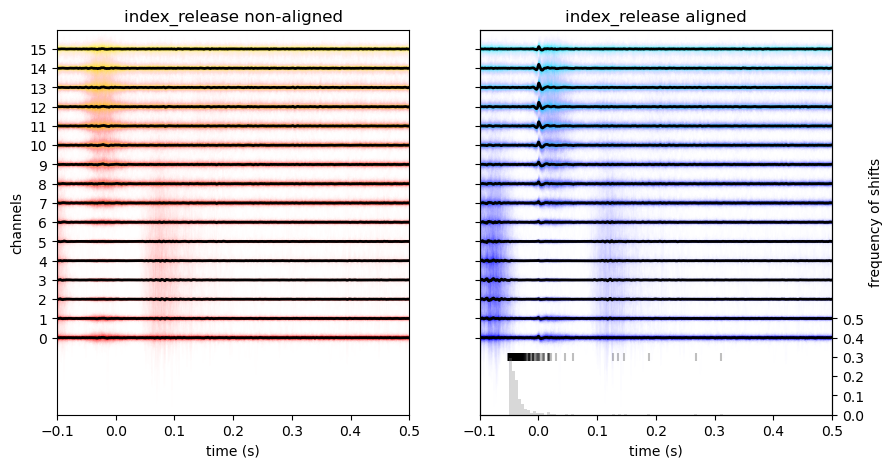

Could not find a large event middle_press 0


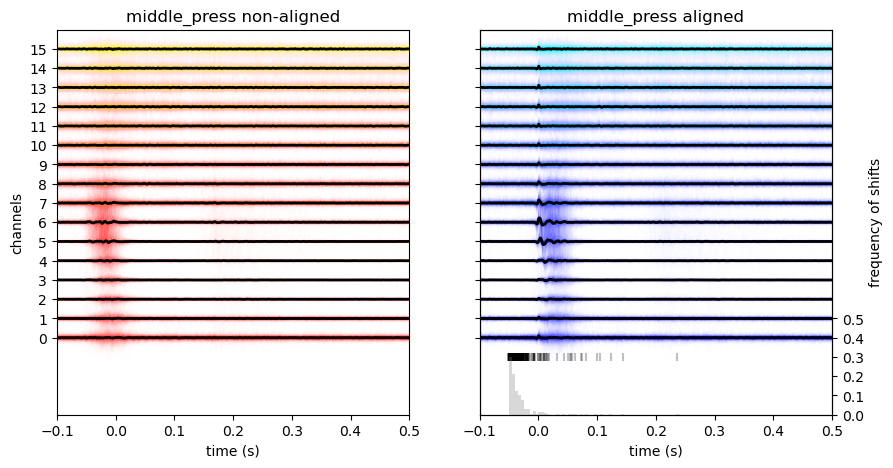

Could not find a large event middle_release 0
Lower threshold used middle_release 290
Lower threshold used middle_release 304


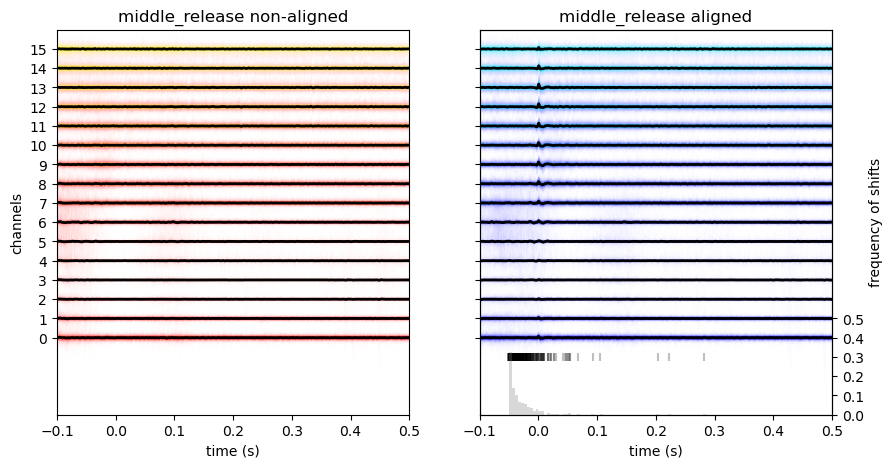

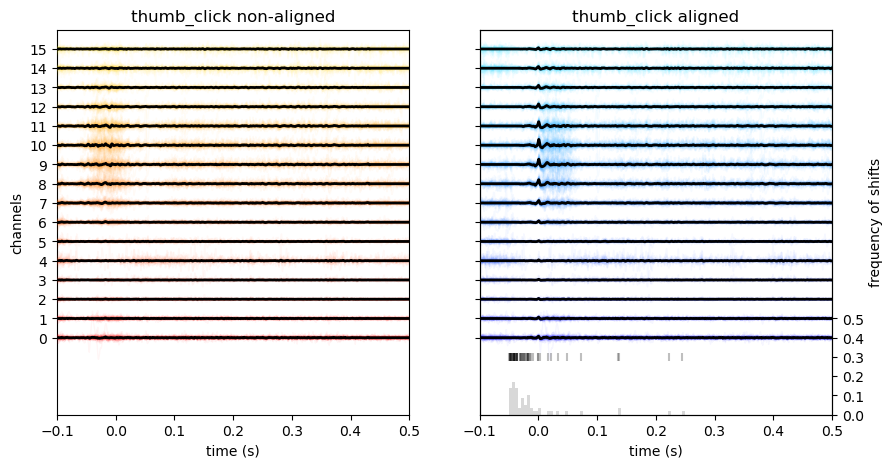

Lower threshold used thumb_down 0


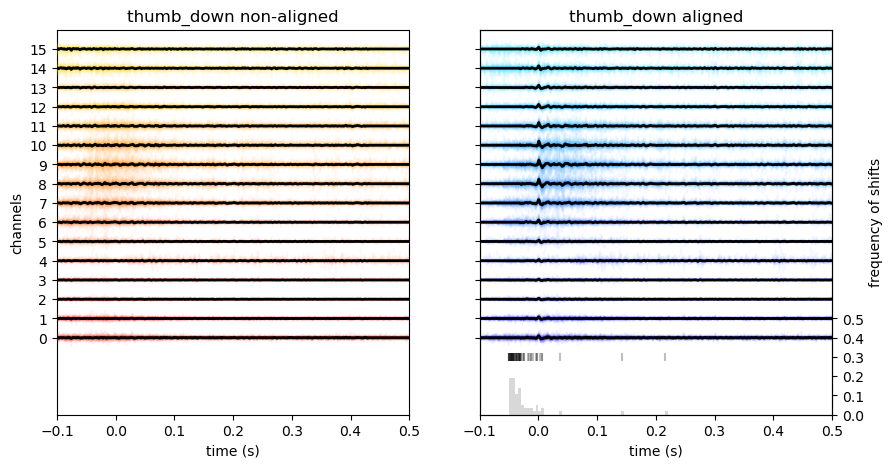

Lower threshold used thumb_in 0


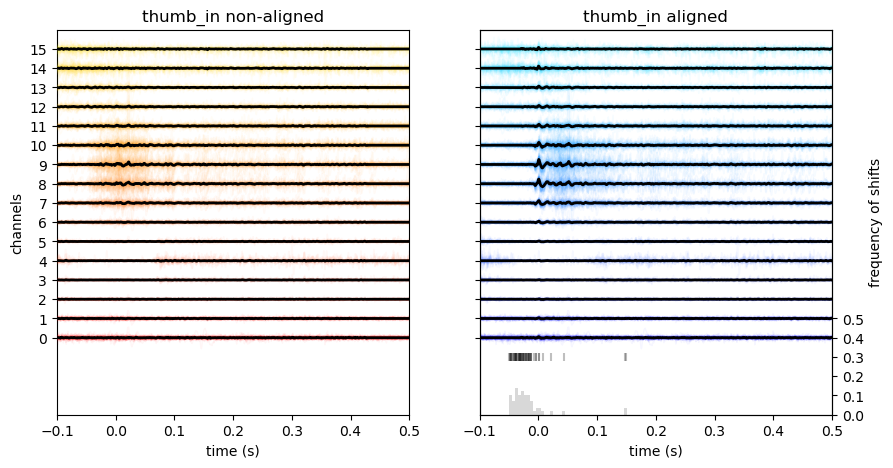

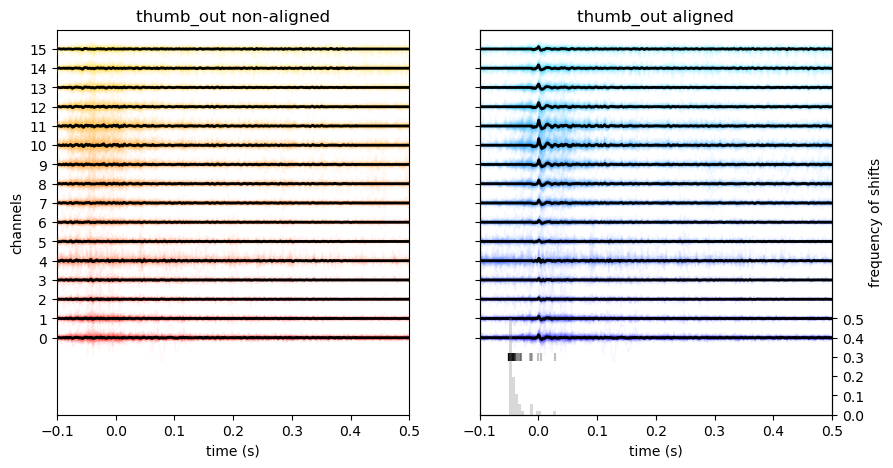

Lower threshold used thumb_up 0


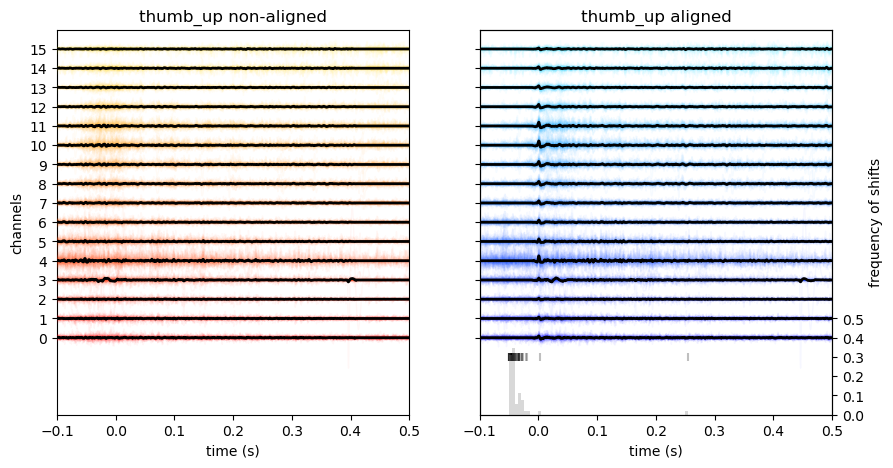

In [53]:
sample_rate = 2000
window_size = np.array([-.05, 1.5])*sample_rate #test window of how much we are willing to allow a shift, 0.05 sec is my low end
view_window = np.array([-.1, .5])*sample_rate #window we are viewing
time_rel = np.arange(view_window[0], view_window[1])/sample_rate # time oif view window, with 0 at the event
all_gestures = np.unique(gesture_labels) # all unique gestures

for gesture in all_gestures:
    if gesture == '': # skip empty gestures
        continue

    gest_indices = np.where(gesture_labels == gesture)[0] # find index of these gestures
    # print(stage_labels[gest_indices])
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    shifts = np.zeros_like(gest_indices)
    for i, index in enumerate(gest_indices): # loop through waveforms of gestures
        
        start = int(window_size[0] + index) #non-shifted search window, 0 is prompt time
        stop = int(window_size[1] + index)
        current_z = zscore[start:stop,:]
        
        # determine big event, independent of channel
        try:
            large_event = np.where(np.max(current_z, axis=1) > 3)[0][0] # first event that reaches a zscore of 3 (3 * stdev)
        except Exception as e:
            try:
                large_event = np.where(np.max(current_z, axis=1) > 1.65)[0][0] # else first event that reaches a zscore of 1.65, alpha=0.05
                print('Lower threshold used', gesture, i)
            except:
                print('Could not find a large event' , gesture, i)
                continue
                
        new_index = start + large_event # new index relative to the start index from this iteration
        shift = new_index - index # how much it shifts
        shifts[i] = shift

        start = int(view_window[0] + index) #non-shifted view window, 0 is prompt time
        stop = int(view_window[1] + index)
        current_z = zscore[start:stop,:]
        
        startl = int(view_window[0] + new_index) #shifted indices
        stopl = int(view_window[1] + new_index)
        
        current_e = emg[startl:stopl,:] # emg value, shifted, 0 is first large muscle movement around prompt time
        new_current_z = zscore[startl:stopl,:] # zscore, shifted, 0 is first large muscle movement around prompt time
        
        if i == 0: #sum all 16 channels of which window
            noalign_zmean = current_z #zscore aligned to prompt
            emean = current_e #emg aligned to large event
            zmean = new_current_z #zscore aligned to large event
        else:
            noalign_zmean += current_z
            emean += current_e 
            zmean += new_current_z
            
        for j in range(16):
            if gesture[:5]=='thumb': # fewer events, higher alpha
                axs[0].plot(time_rel, current_z[:,j] + 10*j, 
                            color=(1,j/16,0), linewidth=1, alpha=1/30, zorder = 10)
                axs[1].plot(time_rel, new_current_z[:,j] + 10*j, 
                            color=(0,j/16,1), linewidth=1, alpha=1/30, zorder = 10)
            else: # more events, lower alpha, 1/255 is the lowest based on 8 bit color schemes
                axs[0].plot(time_rel, current_z[:,j] + 10*j, 
                            color=(1,j/16,0), linewidth=1, alpha=1/255, zorder = 10)
                axs[1].plot(time_rel, new_current_z[:,j] + 10*j, 
                            color=(0,j/16,1), linewidth=1, alpha=1/255, zorder = 10)
        axs[1].scatter(shift/sample_rate, -10, marker='|', color='black', alpha=0.25) #plot the shift 
    
    noalign_zmean /= i #create mean by dividing by the number of iterations
    emean /= i 
    zmean /= i
    
    
    for j in range(16):
        axs[0].plot(time_rel, noalign_zmean[:,j] + 10*j, 
                    color=(0,0,0), linewidth=2, alpha=1, zorder = 100)
        axs[1].plot(time_rel, zmean[:,j] + 10*j, 
                    color=(0,0,0), linewidth=2, alpha=1, zorder = 100)
    
    axs[0].set_title(gesture+ ' non-aligned')
    axs[0].set_yticks(np.arange(16)*10)
    axs[0].set_yticklabels(np.arange(16))
    axs[0].set_ylabel('channels')
    axs[0].set_xlim(view_window/sample_rate)
    axs[0].set_ylim(-40, 160)
    axs[0].set_xlabel('time (s)')
    
    axs[1].set_title(gesture + ' aligned')
    axs[1].set_yticks(np.arange(16)*10)
    axs[1].set_yticklabels([])
    axs[1].set_xlim(view_window/sample_rate)
    axs[1].set_xlabel('time (s)')
    axs[1].set_ylim(-40, 160)
   
    # ax0 = axs[0].twinx()
    # ax0.hist(0+(shifts/sample_rate), weights = np.ones(shifts.size)/shifts.size,
    #          bins=np.arange(view_window[0],view_window[1],10)/sample_rate, color='grey', alpha=0.3)
    # ax0.set_ylabel('prob of time shift based on large event')
    
    ax1 = axs[1].twinx()
    ax1.hist(shifts/sample_rate, weights = np.ones(shifts.size)/shifts.size,
             bins=np.arange(view_window[0],view_window[1],10)/sample_rate, color='grey', alpha=0.3)
    
    ax1.set_ylim(0,2)
    ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax1.set_ylabel('frequency of shifts')

    plt.show()
    # outside = np.sum(shifts/sample_rate < -0.1)
    # print('Number of shifts outside of the viewing window: {0}/{1}: {2}%'.format(outside, shifts.shape[0], np.round(outside/shifts.shape[0] * 100 ,2)))

In [17]:
'''
this produces a matrix to store the index for each gesture.  
Row corresponds individual gestures in order of 'gesture_names'
'''

#Prepare an array to hold the gesture label for each sample (default: empty string)
if not prompts.empty:
    prompt_times = prompts['time'].values
    prompt_names = prompts['name'].values
    
    gesture_names = np.unique(prompt_names)
    max_iter = 0
    for g, gesture in enumerate(gesture_names):
        print(gesture, np.sum(prompt_names==gesture))
        if max_iter < np.sum(prompt_names==gesture):
            max_iter = np.sum(prompt_names==gesture)
    
    gesture_labels_matrix = np.zeros((len(gesture_names), max_iter)) * np.nan
    for g, gesture in enumerate(gesture_names):
        gest_loc = np.where(prompt_names==gesture)[0] #find index of gestures
        index_loc = np.zeros_like(gest_loc) #make a time index of where these are 
        prompt_times_subset = prompt_times[gest_loc] # pull the times for just this gesture
        for i, ti in enumerate(prompt_times_subset):
            index_loc[i] = np.where(np.round(ti,4)==np.round(time,4))[0] #find the closest index to 1 ms
        
        gesture_labels_matrix[g, :len(gest_loc)] = index_loc

# print(gesture_labels_matrix)
print(np.sum(~np.isnan(gesture_labels_matrix), axis=1)) # check for nan, count those that are not nan




index_press 400
index_release 400
middle_press 400
middle_release 400
thumb_click 60
thumb_down 60
thumb_in 60
thumb_out 60
thumb_up 60


/var/folders/nt/_5lxb3_s6yl37rq6nmtyws4m0000gp/T/ipykernel_66960/3580373974.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_loc[i] = np.where(np.round(ti,4)==np.round(time,4))[0] #find the closest index to 1 ms


[[ 454880.  456790.  469570. ... 4639160. 4645010. 4650560.]
 [ 455470.  457200.  469980. ... 4640540. 4646780. 4652920.]
 [ 451390.  458820.  460840. ... 4600100. 4658180. 4663180.]
 ...
 [2346110. 2360730. 2365570. ...      nan      nan      nan]
 [2342610. 2363290. 2368830. ...      nan      nan      nan]
 [2349290. 2353980. 2359170. ...      nan      nan      nan]]


array([400, 400, 400, 400,  60,  60,  60,  60,  60])